In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import argparse
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from models.soft_shift_net.soft_shiftnet_model import ShiftNetModel
from options.train_options import TrainOptions 
from models import networks
import numpy as np
import warnings
warnings.simplefilter("ignore")

In [2]:
import util
from util.util import *
from collections import namedtuple 

In [3]:
optClass = namedtuple('Options', ['fineSize'])

In [4]:
opt = optClass(fineSize=256)
opt.fineSize

256

In [5]:
%time mask = wrapper_gmask(opt)

CPU times: user 396 ms, sys: 20 ms, total: 416 ms
Wall time: 216 ms


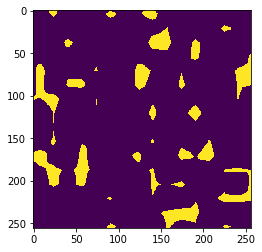

In [6]:
plt.imshow(np.squeeze(mask))

In [7]:
import skimage
from skimage.transform import resize

In [8]:
masks = []
for _ in range(1000):
    mask = wrapper_gmask(opt).cpu().numpy()
    masks.append(resize(np.squeeze(mask), (64, 64)))
masks = np.array(masks)

In [9]:
#masks = masks.reshape((1000, -1))

In [10]:
mean = np.mean(masks) 
masks[masks >= mean] = 1
masks[masks < mean] = 0

In [11]:
masks.shape

(1000, 64, 64)

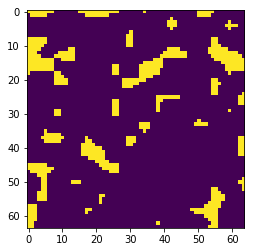

In [12]:
plt.imshow(masks[0])

In [13]:
masks = masks.astype(np.int)
masks = masks.reshape((1000, -1))

In [14]:
class OptimizerMask:
    
    def __init__(self, masks, stop_criteria=0.85):
        self.masks = masks
        self.indexes = []
        self.stop_criteria = stop_criteria
        
        
    def get_iou(self):
        intersection = np.matmul(masks, masks.T)
        diag = np.diag(intersection)
        outer_add = np.add.outer(diag, diag)
        self.iou = intersection / outer_add 
        self.shape = self.iou.shape
        
    def _is_finished(self):
        masks = self.masks[self.indexes]
        #print(masks.shape)
        masks = np.sum(masks, axis=0)
        #print(masks.shape)
        masks[masks > 0] = 1
        plt.imshow(masks.reshape((64, 64)))
        area_coverage = np.sum(masks)/np.product(masks.shape)
        #print(area_coverage)
        if area_coverage < self.stop_criteria:
            return False
        else:
            return True
        
    def mean(self):
        _mean = np.mean(np.sum(self.masks[self.indexes], axis=-1))/(64*64)
        print(_mean)
        
    def _get_next_indexes(self):
        ious = self.iou[self.indexes]
        _mean_iou = np.mean(ious, axis=0)
        idx = np.argmin(_mean_iou)
        #print(idx)
        self.indexes = np.append(self.indexes, np.argmin(_mean_iou))
        
    def _solve(self):
        self.indexes = list(np.unravel_index(np.argmin(self.iou), self.shape))
        #print(self.indexes)
        while not self._is_finished():
            self._get_next_indexes()
            
    def get_masks(self):
        masks = self.masks[self.indexes]
        full = np.ones_like(masks[0])
        left = full - np.mean(masks, axis=0)
        return np.append(masks, left).reshape((-1, 64, 64))
    
    def solve(self):
        self._solve()
        

In [15]:
opti = OptimizerMask(masks)

In [16]:
opti.get_iou()

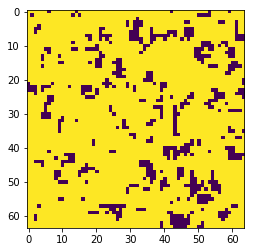

In [17]:
opti.solve()

In [18]:
opti.mean()

0.08525933159722222


In [19]:
output = opti.get_masks()

In [20]:
output.shape

(19, 64, 64)

In [21]:
masks = np.array([resize(mask, (256, 256)) for mask in output])

In [22]:
masks[masks > 0] = 1

In [23]:
masks[-1] = 1 - np.max(masks[:-1], axis=0)

In [24]:
masks[-1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

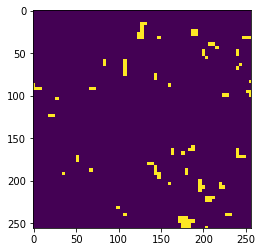

In [25]:
plt.imshow(masks[-1])

In [26]:
from skimage.morphology import *

In [27]:
masks[-1] = dilation(masks[-1], diamond(5))

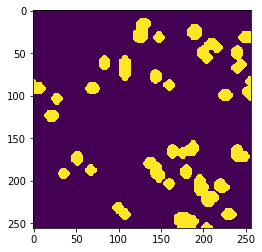

In [28]:
plt.imshow(masks[-1])

# DEFINE THE MODEL

In [29]:
dataroot = '/mnt/hdd2/AIM/DAGM/Class3' # ENTER HERE THE PATH YOU WANT TO USE AS DATAROOT
which_model_netG = 'acc_unet_shift_triple'
add_mask2input = 'True'
model = 'soft_shiftnet'
dataset_mode = 'aligned_resized'
options = '--dataroot {} --which_model_netG {} --add_mask2input {} --model {} --dataset_mode {}'.format(dataroot, which_model_netG, add_mask2input, model, dataset_mode).split(' ')

In [30]:
def get_parser(options=None):
    parser = TrainOptions()
    parser.parse(options=options)
    return parser

In [31]:
parser = get_parser(options=options)
opt = parser.opt

----------------- Options ---------------
           add_mask2input: True                          	[default: False]
                batchSize: 1                             
                    beta1: 0.5                           
               bottleneck: 512                           
          checkpoints_dir: ./log                         
                constrain: MSE                           
           continue_train: False                         
                 dataroot: /mnt/hdd2/AIM/DAGM/Class3     	[default: ./datasets/Paris/train]
             dataset_mode: aligned_resized               	[default: aligned]
             display_freq: 10                            
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
display_single_pane_ncols: 0                             
          display_

In [32]:
from models import create_model
from collections import OrderedDict

In [33]:
model = create_model(opt)

soft_shiftnet
input_nc 4
output_nc 3
which_model_netG acc_unet_shift_triple
[CREATING] MODEL
UnetSkipConnectionBlock(
  (model): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace)
    (1): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
)
[CREATED] MODEL
Constraint in netG:
[InnerCos(skip: True ,strength: 1)]
Shift in netG:
[AcceleratedInnerShiftTriple(threshold: 0.3125 ,triple_weight 1)]
initialize network with normal
initialize network with normal
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.945 M
[Network D] Total number of parameters : 7.988 M
-----------------------------------------------
model [SoftShiftNetModel] was created


In [34]:
os.listdir('/mnt/hdd2/AIM/checkpoints/')

['17_12_2018_Class7_0',
 'class3_b16',
 'class4_0',
 'class4_basic_b8',
 'class3_basic_b8',
 '20_12_2018_Class3_1',
 '17_12_2018_Class10_0',
 'class3_1',
 '20_12_2018_Class3_2',
 '20_12_2018_Class3_0',
 '14_12_2018_1_Class4_0',
 '17_12_2018_Class8_0',
 '14_12_2018_2_Class5_0',
 'class4_1',
 '14_12_2018_Class2_0',
 '17_12_2018_Class10_1',
 '17_12_2018_Class9_0',
 '14_12_2018_Class3_1',
 'class4_2',
 '14_12_2018_1_Class3_1',
 'class3_basic_b4',
 '14_12_2018_Class3_0',
 'batch_8',
 'class3_0',
 '14_12_2018_Class5_0']

In [35]:
path_weights = '/mnt/hdd2/AIM/checkpoints/20_12_2018_Class3_0/latest_net_G.pth'

In [36]:
weights = torch.load(path_weights)

In [37]:
list(weights.keys())[0]

'model.model.0.weight'

In [38]:
new_state = OrderedDict()
for k in weights.keys():
    new_k = 'module.'+k
    new_state[new_k] = weights[k]

In [39]:
list(model.netG.state_dict().keys())[0]

'module.model.model.0.weight'

In [40]:
model.netG.load_state_dict(new_state, strict=True)

# CREATE DATASET

In [41]:
from data.data_loader import CreateDataLoader
from util.util import tensor2im, hist_match

In [42]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()

CustomDatasetDataLoader
dataset [AlignedDatasetResized] was created


In [50]:
def mask2tensor(mask):
    return torch.ByteTensor(mask[np.newaxis, ...][np.newaxis, ...]).cuda()


tensor(-0.9373) tensor(0.9608)
['/mnt/hdd2/AIM/DAGM/Class3/155.png']
7 250


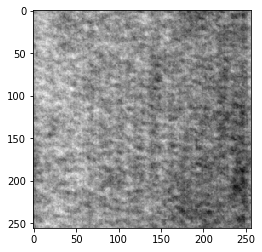

0.0 1.0
100.0 170.5
0.0 1.0


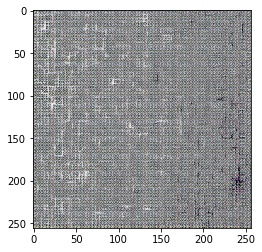

0.7503429355281207


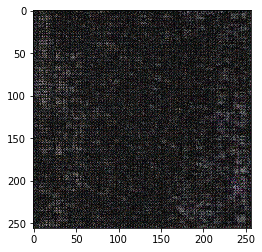

In [56]:
max_error = []
for i, data in enumerate(dataset):
    
    #print('i {}'.format(i))
    img = data['A']
    print(img.min(), img.max())
    img_A = tensor2im(data['A'])
    p = data['A_paths']
    print(p)
    print(img_A.min(), img_A.max())
    plt.imshow(img_A)
    plt.show()
    fake_holder = np.zeros((256, 256, 3))
    fake_sum = np.zeros((256, 256, 1))
    
    for mask in masks:
        m = mask2tensor(mask)
        #print(m.shape)
        model.set_input_with_mask(data, m)
        model.forward()

        fake_B = model.fake_B
        fake_B = tensor2im(fake_B)
        mask = mask[..., np.newaxis]
        m = np.tile(mask, (1, 1, 3))
        fake_holder[m == 1] += fake_B[m == 1]
        fake_sum += mask
    
    img_A = img_A.astype(np.float)
    img_A-=img_A.min()
    img_A/=img_A.max()
    print(img_A.min(), img_A.max())
    rec = fake_holder/fake_sum.astype(np.float)
    print(rec.min(), rec.max())
    rec-=rec.min()
    rec/=rec.max()    
    rec = hist_match(rec, img_A)
    print(rec.min(), rec.max())
    img_A = img_A.astype(np.float)
    
    plt.imshow(rec)
    plt.show()
    
    diff = np.abs(img_A - rec).astype(np.float)
    max_error.append([p, np.max(diff)])
    print(np.max(diff))
    #diff/=np.max(diff)
    plt.imshow(diff)
    plt.show()
    break

In [ ]:
plt.hist(np.array(max_error)[:, 1])

In [ ]:
rec = fake_holder/fake_sum.astype(np.float)

In [ ]:
rec-=rec.min()
rec/=rec.max()

In [ ]:
img_A = img_A.astype(np.float)
img_A-=img_A.min()
img_A/=img_A.max()

In [ ]:
plt.imshow(img_A)

In [ ]:
plt.imshow(rec)

In [ ]:
plt.imshow(np.abs(img_A - rec))

In [ ]:
plt.imshow(np.squeeze(fake_sum))

In [ ]:
fake_sum.max()